In [1]:
import numpy as np
import pandas 

from sklearn.preprocessing import normalize # , LabelEncoder

# Read the info about features
print('Reading feature info...')
data_info = pandas.read_csv("NUSW-NB15_features.csv", encoding = "ISO-8859-1", header=None).values
features = data_info[1:-2,:]
feature_names = features[:, 1]  # Names of the features in a list
feature_types = np.array([item.lower() for item in features[:, 2]])  # The types of the corresponding features in 'features_names'
                         
# index arrays for different types of features
print('Finding column indices for feature types...')
nominal_cols = np.where(feature_types == "nominal")[0]
integer_cols = np.where(feature_types == "integer")[0]
binary_cols = np.where(feature_types == "binary")[0]
float_cols = np.where(feature_types == "float")[0]

# arrays for names of the different types of features
nominal_names = feature_names[nominal_cols]
integer_names = feature_names[integer_cols]
binary_names = feature_names[binary_cols]
float_names = feature_names[float_cols]

print('Reading csv files...')
dataframe1 = pandas.read_csv("UNSW-NB15_1.csv", header=None)
dataframe2 = pandas.read_csv("UNSW-NB15_2.csv", header=None)
dataframe3 = pandas.read_csv("UNSW-NB15_3.csv", header=None)
dataframe4 = pandas.read_csv("UNSW-NB15_4.csv", header=None)

print('Concatenating...')
dataframe = pandas.concat([dataframe1, dataframe2, dataframe3, dataframe4])

del dataframe1
del dataframe2
del dataframe3
del dataframe4

print('Preprocessing...')
print('Converting data...')
dataframe[integer_cols] = dataframe[integer_cols].convert_objects(convert_numeric=True)
dataframe[binary_cols] = dataframe[binary_cols].convert_objects(convert_numeric=True)
dataframe[float_cols] = dataframe[float_cols].convert_objects(convert_numeric=True)
dataframe[48] = dataframe[48].convert_objects(convert_numeric=True)
#dataframe[nominal_cols] = dataframe[nominal_cols].astype(str)

print('Replacing NaNs...')
dataframe.loc[:,47] = dataframe.loc[:,47].replace(np.nan,'normal', regex=True).apply(lambda x: x.strip().lower())
dataframe.loc[:,binary_cols] = dataframe.loc[:,binary_cols].replace(np.nan, 0, regex=True)
dataframe.loc[:,37:39] = dataframe.loc[:,37:39].replace(np.nan, 0, regex=True)
# dataframe.loc[:,float_cols] = dataframe.loc[:,float_cols].replace(np.nan, 0, regex=True)

print('Stripping nominal columns and setting them lower case...')
dataframe.loc[:,nominal_cols] = dataframe.loc[:,nominal_cols].applymap(lambda x: x.strip().lower())

print('Changing targets \'backdoors\' to \'backdoor\'...')
dataframe.loc[:,47] = dataframe.loc[:,47].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

dataset = dataframe.values

del dataframe

# Subsets of the dataset which have data that is only of the corresponding data type (nominal, integer etc)
# Columns don't include the target classes (the two last columns of the dataset)
print('Slicing dataset...')
nominal_x = dataset[:, nominal_cols][:,:]
integer_x = dataset[:, integer_cols][:,:].astype(np.float32)    
binary_x = dataset[:, binary_cols][:,:].astype(np.float32)
float_x = dataset[:, float_cols][:,:].astype(np.float32)
# aon_x = dataset[:, 48][np.newaxis,:].astype(np.float32).transpose()  # Attack or not (binary)

# Make nominal (textual) data binary vectors
print('Vectorizing nominal data...')
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
# D = [{'foo': 1, 'bar': 2}, {'foo': 3, 'baz': 1}]
D = map(lambda dataline: dict(zip(nominal_names, dataline)), nominal_x)
labeled_nominal_x = v.fit_transform(D).astype(np.float32)
del nominal_x

print('Concatenating X...')
X = np.concatenate((integer_x, labeled_nominal_x, float_x, binary_x), axis=1)

del integer_x
del labeled_nominal_x
del float_x
del binary_x

# Find rows that have NaNs
print('Removing NaNs if any...')
nan_indices = []
for feature_i in range(X.shape[1]):
    nan_indices.extend(list(np.where(np.isnan(X[:, feature_i]))[0]))
nan_indices = np.unique(nan_indices)

# Remove rows that have NaNs
X_no_nans = np.delete(X, nan_indices, axis=0)

del X

print('Normalizing X...')
normalized_X = normalize(X_no_nans, copy=False)

del X_no_nans


data_dim = normalized_X.shape
print('Data dimensions are', data_dim)

print('Creating target Y matrix...')
Y = np.delete(dataset[:, -2], nan_indices)
Y_A = np.delete(dataset[:, -1], nan_indices).astype(np.int16) # Is attack or not

del dataset

'''
# Remove same rows as in X to have correct y's
Y_no_nans = np.delete(Y, nan_indices, axis=0)
'''
print('Vectorizing Y labels...')
D = [{'attack_cat': y} for y in Y]
labeled_Y = v.fit_transform(D)

del D

print('Saving normalized X and labeled Y to HDF5')
import h5py
h5f = h5py.File('data.h5', 'w')
h5f.create_dataset('normalized_X', data=normalized_X)
h5f.create_dataset('labeled_Y', data=labeled_Y)
dt = h5py.special_dtype(vlen=str)
h5f.create_dataset('Y', data=Y, dtype=dt)
h5f.create_dataset('Y_A', data=Y_A)
h5f.close()

del Y
del normalized_X
del labeled_Y

Reading feature info...
Finding column indices for feature types...
Reading csv files...


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Concatenating...
Preprocessing...
Converting data...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:42: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:43: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:44: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: FutureWarning: convert_objects i

Replacing NaNs...
Stripping nominal columns and setting them lower case...
Changing targets 'backdoors' to 'backdoor'...
Slicing dataset...
Vectorizing nominal data...
Concatenating X...
Removing NaNs if any...
Normalizing X...
Data dimensions are (2539739, 294)
Creating target Y matrix...
Vectorizing Y labels...
Saving normalized X and labeled Y to HDF5


In [2]:
print('Loading normalized data from HDF5...')
import h5py
h5f = h5py.File('data.h5', 'r')
normalized_X = h5f['normalized_X'].value
labeled_Y = h5f['labeled_Y'].value
Y = h5f['Y'].value
Y_A = h5f['Y_A'].value
h5f.close()


print('Splitting X to test and train datasets...')
# X_test, X_train, Y_test, Y_train = []
rf_normal_inds = []
nn_normal_inds = []
inds = []

attack_cats = np.unique(Y)
cat_sizes = []
np.random.seed(1337)
max_training_samples = 5000
print('Select max', max_training_samples, 'samples for training...')
for cat in attack_cats:
    indices = np.ix_(Y == cat)[0]
    # total_num_of_samples = indices.shape[0]
    np.random.shuffle(indices)
    if cat == 'normal':
        len_of_subset = min(np.floor(len(indices)*0.9), 31000)
        rf_normal_inds = indices[:len_of_subset]
        nn_normal_inds = indices[:len_of_subset][:max_training_samples]
        cat_size = len(indices)
        print(cat, ': training samples =', len_of_subset, '| total samples =', cat_size)
    else:
        len_of_subset = min(np.floor(len(indices)*0.9), max_training_samples)

        cat_size = len(indices)
        print(cat, ': training samples =', len_of_subset, '| total samples =', cat_size)
        cat_sizes.append(cat_size)
        #inds.extend(oversampled_indices)
        inds.extend(indices[:int(len_of_subset)])


print('Number of categories is', len(cat_sizes), '| Total samples in categories:\n|', '\n|'.join([str(i)+': '+str(c) for i, c in enumerate(cat_sizes)]))
print('normal samples for rf:', len(rf_normal_inds))
print('normal samples for nn:', len(nn_normal_inds))

# Attack or not learning data
rf_inds = []
rf_inds.extend(inds)
rf_inds.extend(rf_normal_inds)
X_rf_train = normalized_X[rf_inds, :]
X_rf_test = np.delete(normalized_X, rf_inds, axis=0)

Y_rf_train = Y_A[rf_inds]
Y_rf_test = np.delete(Y_A, rf_inds, axis=0)

# Category learning data
nn_inds = []
nn_inds.extend(inds)
nn_inds.extend(nn_normal_inds)
X_nn_train = normalized_X[nn_inds, :]
# Remove rf indices because nn indices is a subset and we dont want to test and train with same data
X_nn_test = np.delete(normalized_X, rf_inds, axis=0)

del normalized_X

Y_nn_train = labeled_Y[nn_inds]
Y_nn_train_string = Y[nn_inds]

Y_nn_test = np.delete(labeled_Y, rf_inds, axis=0)
Y_nn_test_string = np.delete(Y, rf_inds, axis=0)

del labeled_Y
del Y

Y_nn_A_train = Y_A[nn_inds]
Y_nn_A_test = np.delete(Y_A, rf_inds, axis=0)

del Y_A



Loading normalized data from HDF5...


/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Splitting X to test and train datasets...
Select max 5000 samples for training...
analysis : training samples = 2409.0 | total samples = 2677
backdoor : training samples = 2096.0 | total samples = 2329
dos : training samples = 5000 | total samples = 16353
exploits : training samples = 5000 | total samples = 44525
fuzzers : training samples = 5000 | total samples = 24246
generic : training samples = 5000 | total samples = 215481
normal : training samples = 31000 | total samples = 2218456
reconnaissance : training samples = 5000 | total samples = 13987
shellcode : training samples = 1359.0 | total samples = 1511
worms : training samples = 156.0 | total samples = 174
Number of categories is 9 | Total samples in categories:
| 0: 2677
|1: 2329
|2: 16353
|3: 44525
|4: 24246
|5: 215481
|6: 13987
|7: 1511
|8: 174
normal samples for rf: 31000
normal samples for nn: 5000


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.figure(figsize=(12,5))
sns.countplot(y=Y_nn_A_train)

In [4]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_nn_train, Y_nn_A_train)

Using TensorFlow backend.


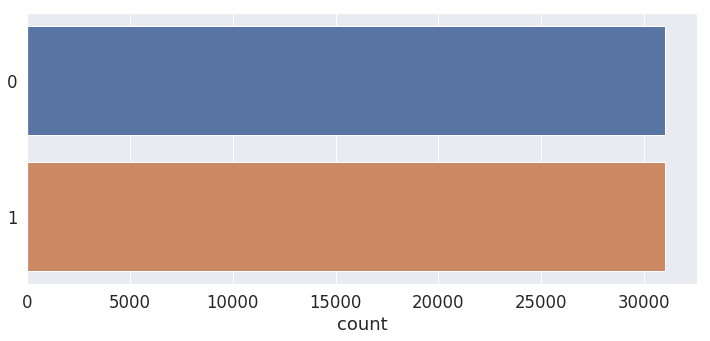

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.figure(figsize=(12,5))
sns.countplot(y=y_train_res)

['analysis' 'analysis' 'analysis' ... 'normal' 'normal' 'normal']


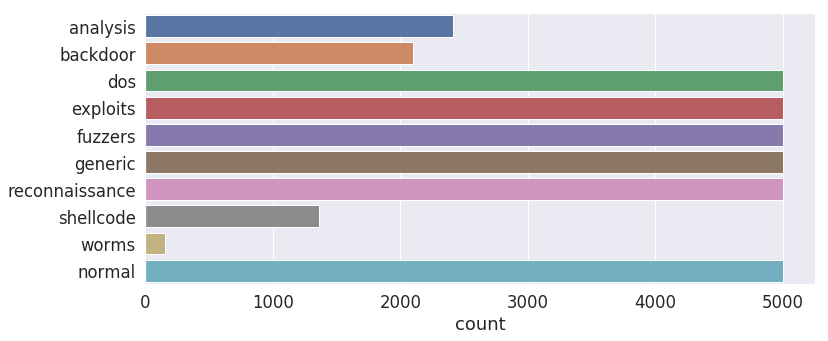

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.figure(figsize=(12,5))
sns.countplot(y=Y_nn_train_string)
print(Y_nn_train_string)

In [7]:
from imblearn.over_sampling import SMOTE
sm = SMOTE('all')
x_train_res_cat, y_train_res_cat = sm.fit_sample(X_nn_train, Y_nn_train_string)

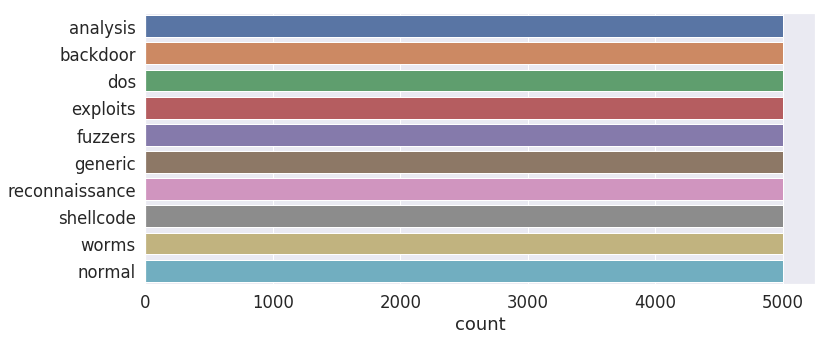

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.figure(figsize=(12,5))
sns.countplot(y=y_train_res_cat)

Finding feature importances with RandomForestClassifier


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1. feature 284 (0.327144)
2. feature 283 (0.194674)
3. feature 5 (0.076534)
4. feature 13 (0.057604)
5. feature 12 (0.044128)
6. feature 2 (0.043916)
7. feature 268 (0.037527)
8. feature 195 (0.029580)
9. feature 4 (0.025903)
10. feature 3 (0.025902)


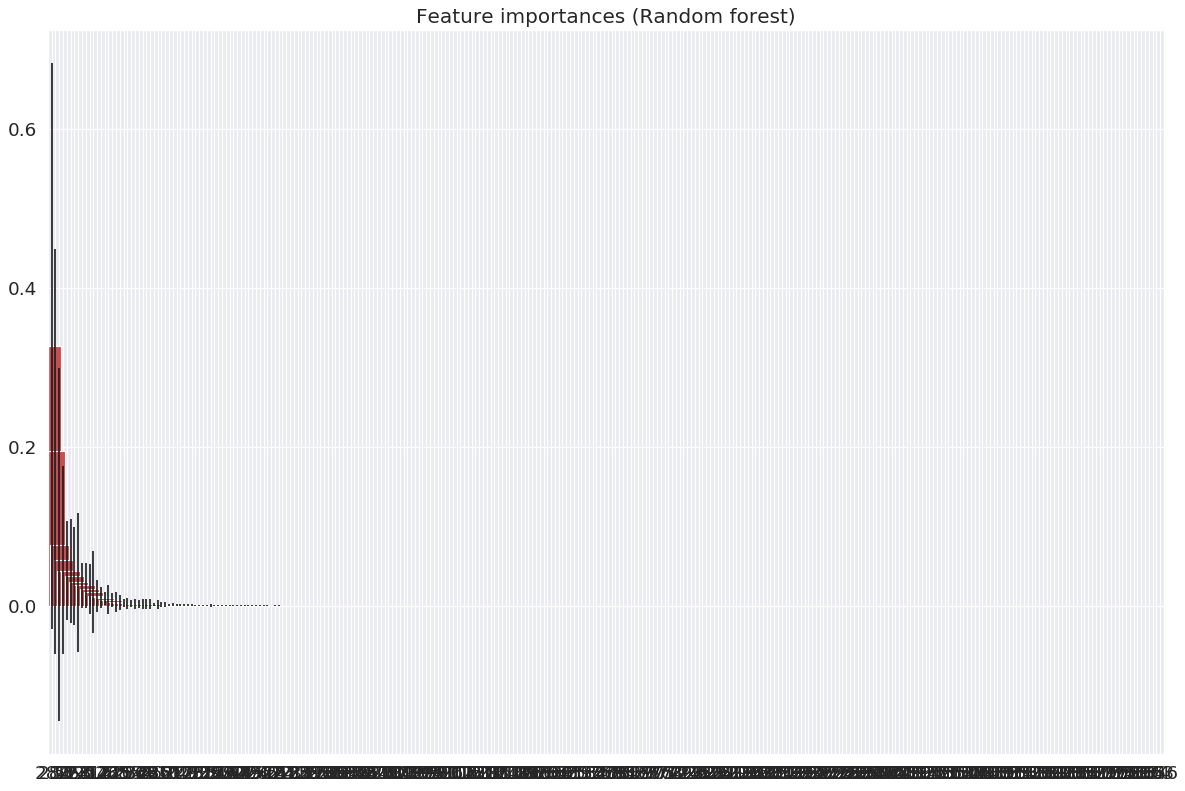

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1. feature 0 (0.232829)
2. feature 285 (0.117926)
3. feature 1 (0.068073)
4. feature 14 (0.067138)
5. feature 284 (0.063450)
6. feature 2 (0.062237)
7. feature 4 (0.052312)
8. feature 13 (0.039038)
9. feature 5 (0.033838)
10. feature 283 (0.033056)


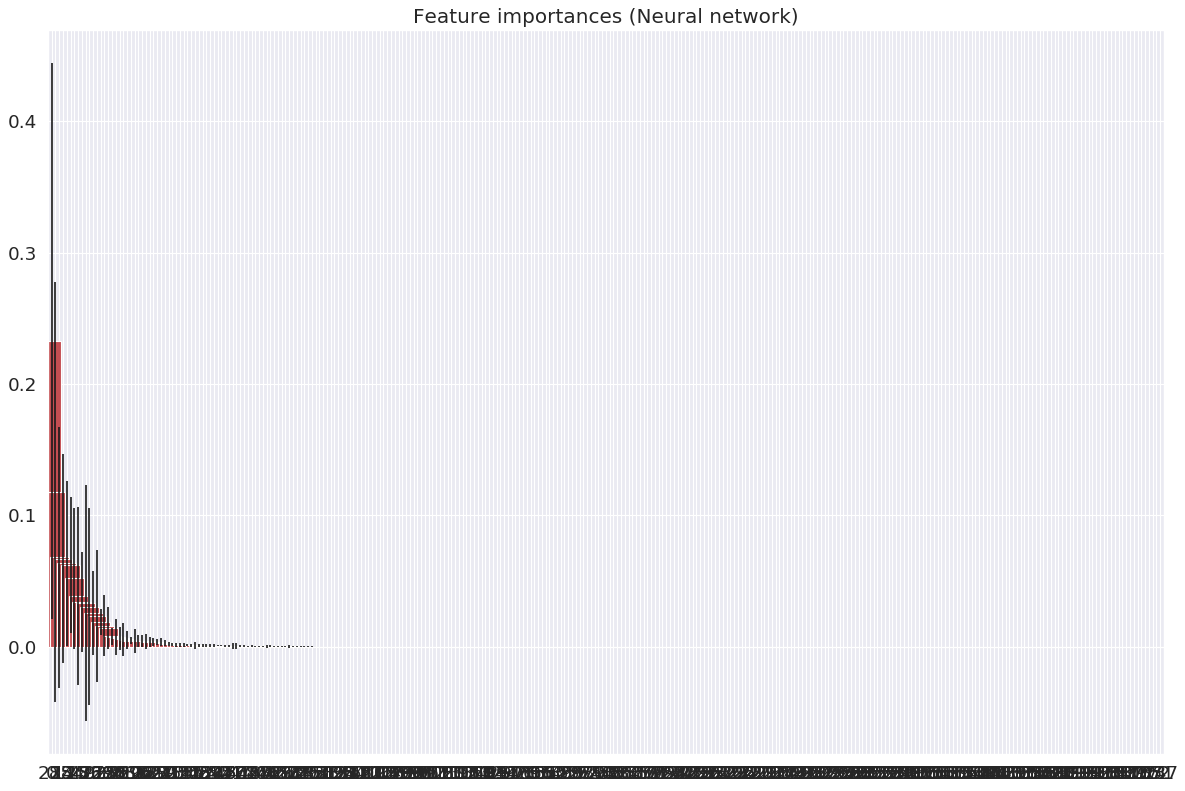

NB_NN_FEATURES  295
nn_indices len 295
X_nn_test  [[1.74143282e-03 6.63999526e-05 1.65373480e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.15681845e-01 9.60334577e-03 4.95172478e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.77898607e-03 6.44031825e-05 1.77412541e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.11019378e-05 2.06006536e-08 1.76773233e-06 ... 1.29489830e-13
  0.00000000e+00 1.96196703e-09]
 [9.65431627e-06 2.17973444e-08 9.53088886e-07 ... 3.78728827e-14
  0.00000000e+00 0.00000000e+00]
 [3.58931516e-06 2.28314736e-08 1.19138775e-07 ... 1.77591501e-11
  0.00000000e+00 0.00000000e+00]]


IndexError: index 294 is out of bounds for axis 1 with size 294

In [9]:
print('Finding feature importances with RandomForestClassifier')
from sklearn.ensemble import RandomForestClassifier

def find_importances(X_train, Y_train):
    model = RandomForestClassifier()
    model = model.fit(X_train, Y_train)
    
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]  # Top ranking features' indices
    return importances, indices, std

import matplotlib.pyplot as plt
# Plot the feature importances of the forest
def plot_feature_importances(X_train, importances, indices, std, title):
   
    for f in range(10):
      print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    plt.figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.title(title)
    width=5
    plt.bar(range(X_train.shape[1]), importances[indices],
          width=5, color="r", yerr=std[indices], align="center") #tagy 1.5 > .8
    plt.xticks(range(X_train.shape[1]), indices)
    #plt.axis('tight')
    plt.xlim([-1, X_train.shape[1]]) # -1 tagy
    plt.show()

    

rf_importances, rf_indices, rf_std = find_importances(X_rf_train, Y_rf_train)

plot_feature_importances(X_rf_train, rf_importances, rf_indices, rf_std, title='Feature importances (Random forest)')

# Neural network is classified with correct 'attack or not' labels
X_nn_train = np.concatenate((Y_nn_A_train[:,np.newaxis], X_nn_train), axis=1)
nn_importances, nn_indices, nn_std = find_importances(X_nn_train,
                                                      Y_nn_train)
plot_feature_importances(X_nn_train,
                        nn_importances, nn_indices, nn_std, title='Feature importances (Neural network)')

#NB_RF_FEATURES = 10
#NB_NN_FEATURES = 25
NB_RF_FEATURES = X_rf_train.shape[1]
NB_NN_FEATURES = X_nn_train.shape[1]

reduced_X_nn_train = X_nn_train[:, nn_indices[0:NB_NN_FEATURES]]
reduced_Y_nn_train = Y_nn_train
reduced_Y_nn_train_string = Y_nn_train_string
reduced_Y_nn_test_string = Y_nn_test_string
reduced_Y_nn_A_train = Y_nn_A_train

# Test set has 1 less because we get the one from RF
print("NB_NN_FEATURES ", NB_NN_FEATURES)
print("nn_indices len", len(nn_indices))
print("X_nn_test ", X_nn_test)

reduced_X_nn_test = X_nn_test[:, nn_indices[1:NB_NN_FEATURES]]
reduced_Y_nn_test = Y_nn_test


reduced_X_rf_train = X_rf_train[:, rf_indices[0:NB_RF_FEATURES]]
reduced_Y_rf_train = Y_rf_train

reduced_X_rf_test = X_rf_test[:, rf_indices[0:NB_RF_FEATURES]]
reduced_Y_rf_test = Y_rf_test

print('Saving X and Y to HDF5')
import h5py
h5f = h5py.File('datasets.h5', 'w')
h5f.create_dataset('X_rf_train', data=reduced_X_rf_train)
h5f.create_dataset('X_rf_test',  data=reduced_X_rf_test)
h5f.create_dataset('Y_rf_train', data=reduced_Y_rf_train)
h5f.create_dataset('Y_rf_test',  data=reduced_Y_rf_test)

h5f.create_dataset('X_nn_train', data=reduced_X_nn_train)
h5f.create_dataset('X_nn_test',  data=reduced_X_nn_test)
h5f.create_dataset('Y_nn_train', data=reduced_Y_nn_train)
h5f.create_dataset('Y_nn_test',  data=reduced_Y_nn_test)
dt = h5py.special_dtype(vlen=str)
h5f.create_dataset('Y_nn_train_string', data=reduced_Y_nn_train_string, dtype=dt)
h5f.create_dataset('Y_nn_test_string', data=reduced_Y_nn_test_string, dtype=dt)

h5f.create_dataset('Y_nn_A_train', data=reduced_Y_nn_A_train)
h5f.create_dataset('Y_nn_A_test', data=Y_nn_A_test)

h5f.close()

In [ ]:
# confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    # np.set_printoptions(precision=2)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0:.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
    
    #Roc


def plot_roc_curve(Y_test, Y_pred, nb_classes, class_index, title='Receiver operating characteristic'):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(nb_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y_test[:, i], Y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(Y_test.ravel(), Y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    #plt.figure()
    lw = 2
    plt.plot(fpr[class_index], tpr[class_index], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[class_index])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    #epoch history
    

def plot_hist(hist, metrics, num=None):
    import matplotlib.pyplot as plt
    if num is not None:
        fig = plt.figure(num)
    else:
        fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for metric in metrics:
        ax1.plot(hist.history[metric], label=metric)
    # plt.plot(history.history['val_acc'])
    # ax.ylabel(metric)
    plt.title('model history')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
    plt.legend(loc='upper right');
    plt.show()

In [ ]:
print(X_rf_train.shape[1])

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, merge, Lambda
from keras.models import Model
from keras.optimizers import SGD
import numpy as np

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.regularizers import l2 as activity_l2

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#from sklearn.metrics import confusion_matrix as cm
#from sklearn.metrics import roc_curve as roc
#from mlxtend.plotting import plot_confusion_matrix

#tagy
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.Session(config=config)

print('Loading normalized data from HDF5...')
import h5py
h5f = h5py.File('datasets.h5', 'r')
X_train = h5f['X_nn_train'].value
Y_train = h5f['Y_nn_train'].value.astype(np.float32)
X_test = h5f['X_nn_test'].value
Y_test = h5f['Y_nn_test'].value.astype(np.float32)

X_train2 = h5f['X_rf_train'].value
Y_train2 = h5f['Y_rf_train'].value.astype(np.float32)
X_test2 = h5f['X_rf_test'].value
Y_test2 = h5f['Y_rf_test'].value.astype(np.float32)
h5f.close()


from sklearn.ensemble import RandomForestClassifier

print('Training ExtraTreesClassifier for "attack or not" labels...')
model2 = RandomForestClassifier(n_estimators=100, criterion='entropy')
model2 = model2.fit(X_train2, Y_train2)

Y_pred2 = model2.predict_proba(X_test2)[:,1]

print('Testing accuracy...')
score2 = accuracy_score(Y_test2, np.around(Y_pred2))
print(score2)
print(classification_report(Y_test2, np.around(Y_pred2)))

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TN += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

TP, FP, TN, FN = perf_measure(np.around(Y_pred2), Y_test2)

fp_rate = FP/(TN+FP)
tn_rate = TN/(TN+FP)

accuracy = (TN+TP)/(TN+FP+TP+TN)
precision = TP/(TN+FP)
hitrate = TP/(TN+FN)

print('TP:', TP, 'FP:', FP, 'TN:', TN, 'FN:', FN)
print('Accuracy:', accuracy)
print('False Positive rate:', fp_rate, 'True Negative Rate', tn_rate)

def to_cat(y):
    y_tmp = np.ndarray(shape=(y.shape[0], 2), dtype=np.float32)
    for i in range(y.shape[0]):
        y_tmp[i, :] = np.array([1-y[i], y[i]])   # np.array([0,1]) if y[i] else np.array([1,0])
    return y_tmp


plot_confusion_matrix(Y_test2, np.round(Y_pred2), classes=list(range(2)),
                           normalize=True,
                         title='"Intrusion or normal" confusion matrix')

plot_roc_curve(to_cat(Y_test2), to_cat(Y_pred2), 2, 0, title='Receiver operating characteristic (attack_or_not = 0)')
plot_roc_curve(to_cat(Y_test2), to_cat(Y_pred2), 2, 1, title='Receiver operating characteristic (attack_or_not = 1)')


if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
    
#  Starting Network shit


print('Combining predicted "attack or not" labels to neural network testing data...')
X_test = np.concatenate((Y_pred2[:,np.newaxis], X_test), axis=1)

print('Creating neural network...')
num_of_features = x_train_res.shape[1]
y_train_res= to_cat(y_train_res)
nb_classes = y_train_res.shape[1]

def residual_layer(size, x):
    
    y = Dense(size, activation='sigmoid', W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01))(x)
    # x = Dropout(0.5)(x)
    # print(x.get_shape().as_list()[1])
    y = Dense(x.get_shape().as_list()[1], activation='sigmoid',  W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01))(y)
    res = merge([y, x], mode='sum')
    return res


def baseline_model():
    def branch2(x):
        
        x = Dense(int(np.floor(num_of_features*50)), kernel_initializer ='uniform',activation='sigmoid')(x)
        x = Dropout(0.75)(x)
        
        x = Dense(int(np.floor(num_of_features*20)), kernel_initializer ='uniform',activation='sigmoid')(x)
        x = Dropout(0.5)(x)
        
        x = Dense(int(np.floor(num_of_features)), kernel_initializer ='uniform',activation='sigmoid')(x)
        x = Dropout(0.1)(x)
        return x
    
    main_input = Input(shape=(num_of_features,), name='main_input')

    x = main_input
    x = branch2(x)
    main_output = Dense(nb_classes, activation='softmax')(x)
    model = Model(input=main_input, output=main_output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_crossentropy'])
    return model

model = baseline_model()

print('Training neural network...')
history = model.fit(x_train_res, y_train_res,
                    epochs=100,
                    batch_size=128
                    )

print('Plotting training history data...')
print(history.history.keys())

#from  epoch_history_plot import  plot_hist

plot_hist(history, ['loss', 'acc'])

# summarize history for accuracy
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

print('Testing neural network...')
Y_predicted = model.predict(X_test)

max_probs = np.argmax(Y_predicted, axis=1)
Y_pred = np.zeros(Y_predicted.shape)
for row, col in enumerate(max_probs):
    Y_pred[row,col] = 1

score = accuracy_score(Y_test, Y_pred)
print(score)
print(classification_report(Y_test.argmax(axis=-1), Y_pred.argmax(axis=-1)))


plot_confusion_matrix(Y_test.argmax(axis=-1), Y_pred.argmax(axis=-1), classes=list(range(10)),
                          normalize=True,
                          title='Confusion matrix')

print('Saving neural network model...')
json_string = model.to_json()
with open('neural_model1.json', 'w') as f:
    f.write(json_string)
model.save_weights('neural_model_weights1.h5')

model.save('neural_model1.h5')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, merge, Lambda
from keras.models import Model
from keras.optimizers import SGD
import numpy as np

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.regularizers import l2 as activity_l2

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#from sklearn.metrics import confusion_matrix as cm
#from sklearn.metrics import roc_curve as roc
#from mlxtend.plotting import plot_confusion_matrix

#tagy
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.Session(config=config)

print('Loading normalized data from HDF5...')
import h5py
h5f = h5py.File('datasets.h5', 'r')
X_train = h5f['X_nn_train'].value
Y_train = h5f['Y_nn_train'].value.astype(np.float32)
X_test = h5f['X_nn_test'].value
Y_test = h5f['Y_nn_test'].value.astype(np.float32)

X_train2 = h5f['X_rf_train'].value
Y_train2 = h5f['Y_rf_train'].value.astype(np.float32)
X_test2 = h5f['X_rf_test'].value
Y_test2 = h5f['Y_rf_test'].value.astype(np.float32)
h5f.close()

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TN += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

def to_cat(y):
    y_tmp = np.ndarray(shape=(y.shape[0], 2), dtype=np.float32)
    for i in range(y.shape[0]):
        y_tmp[i, :] = np.array([1-y[i], y[i]])   # np.array([0,1]) if y[i] else np.array([1,0])
    return y_tmp


if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

print('Combining predicted multiple labels to neural network testing data...')
X_test = np.concatenate((Y_pred2[:,np.newaxis], X_test), axis=1)

print('Creating neural network...')
import pandas as pd
num_of_features = x_train_res_cat.shape[1]
onehot = pd.get_dummies(y_train_res_cat)
target_labels = onehot.columns
target = onehot.as_matrix()
nb_classes = target.shape[1]

def residual_layer(size, x):
    
    y = Dense(size, activation='sigmoid', W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01))(x)
    # x = Dropout(0.5)(x)
    # print(x.get_shape().as_list()[1])
    y = Dense(x.get_shape().as_list()[1], activation='sigmoid',  W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01))(y)
    res = merge([y, x], mode='sum')
    return res


def baseline_model():
    def branch2(x):
        
        x = Dense(int(np.floor(num_of_features*50)), kernel_initializer ='uniform',activation='sigmoid')(x)
        x = Dropout(0.75)(x)
        
        x = Dense(int(np.floor(num_of_features*20)), kernel_initializer ='uniform',activation='sigmoid')(x)
        x = Dropout(0.5)(x)
        
        x = Dense(int(np.floor(num_of_features)), kernel_initializer ='uniform',activation='sigmoid')(x)
        x = Dropout(0.1)(x)
        return x
    
    main_input = Input(shape=(num_of_features,), name='main_input')

    x = main_input
    x = branch2(x)
    main_output = Dense(nb_classes, activation='softmax')(x)
    model = Model(input=main_input, output=main_output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_crossentropy'])
    return model

model = baseline_model()

print('Training neural network...')
history = model.fit(x_train_res_cat, target,
                    epochs=100,
                    batch_size=128
                    )

print('Plotting training history data...')
print(history.history.keys())

#from  epoch_history_plot import  plot_hist

plot_hist(history, ['loss', 'acc'])

# summarize history for accuracy
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

print('Testing neural network...')
Y_predicted = model.predict(X_test)

max_probs = np.argmax(Y_predicted, axis=1)
Y_pred = np.zeros(Y_predicted.shape)
for row, col in enumerate(max_probs):
    Y_pred[row,col] = 1

score = accuracy_score(Y_test, Y_pred)
print(score)
print(classification_report(Y_test.argmax(axis=-1), Y_pred.argmax(axis=-1)))


plot_confusion_matrix(Y_test.argmax(axis=-1), Y_pred.argmax(axis=-1), classes=list(range(10)),
                          normalize=True,
                          title='Confusion matrix')

print('Saving neural network model...')
json_string = model.to_json()
with open('neural_model1.json', 'w') as f:
    f.write(json_string)
model.save_weights('neural_model_weights1.h5')

model.save('neural_model1.h5')

plot_roc_curve(Y_test, Y_predicted, nb_classes, 6, title='Receiver operating characteristic (class 6)')
plot_roc_curve(Y_test, Y_predicted, nb_classes, 4, title='Receiver operating characteristic (class 4)')
plot_roc_curve(Y_test, Y_predicted, nb_classes, 2, title='Receiver operating characteristic (class 2)')
plot_roc_curve(Y_test, Y_predicted, nb_classes, 0, title='Receiver operating characteristic (class 0)')